In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import operator
from typing import TypedDict, List, Annotated, Literal, Optional
from pydantic import BaseModel, Field

class Task(BaseModel):
    id: int
    title: str
    goal: str = Field(
        ..., 
        description="One sentence describing what the reader should be able to do/understand after this section."
    )
    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=5,
        description="3-5 concrete, non-overlapping subpoints to cover in this section."
    )
    target_words: int = Field(
        ...,
        description="Target word count for this section (120-450)."
    )
    tags: List[str] = Field(default_factory=list) # default_factory creates a new empty list for each model instance
    requires_research: bool = False
    requires_citations: bool = False
    requires_code: bool = False

In [4]:
class Plan(BaseModel):
    blog_title: str
    audience: str = Field(..., description="Who this blog is for.")
    tone: str = Field(..., description="Writing tone (e.g., practical, crisp).")
    blog_kind: Literal["explainer", "tutorial", "news_roundup", "comparison", "system_design"] = "explainer"
    constraints: List[str] = Field(default_factory=list)
    tasks: List[Task]

In [5]:
class EvidenceItem(BaseModel):
    title: str
    url: str
    published_at: Optional[str] = None
    snippet: Optional[str] = None
    source: Optional[str] = None

In [6]:
class RouterDecision(BaseModel):
    needs_research: bool
    mode: Literal["closed_book", "hybrid", "open_book"]
    queries: List[str] = Field(default_factory=list)

In [7]:
class EvidencePack(BaseModel):
    evidence: List[EvidenceItem] = Field(default_factory=list)

In [8]:
class ImageSpec(BaseModel):
    placeholder: str = Field(..., description="e.g. [[IMAGE_1]]")
    filename: str = Field(..., description="Save under images/, e.g. qkv_flow.png")
    alt: str
    caption: str
    prompt: str = Field(..., description="Prompt to sent to the image model.")
    size: Literal["1024x1024", "1024x1536", "1536x1024"] = "1024x1024"
    quality: Literal["low", "medium", "high"] = "medium"

In [9]:
class GlobalImagePlan(BaseModel):
    md_with_placeholders: str
    images: List[ImageSpec] = Field(default_factory=list)

In [10]:
class State(TypedDict):
    topic: str
    mode: str
    needs_research: bool
    queries: List[str]
    evidence: List[EvidenceItem]
    plan: Optional[Plan]
    sections: Annotated[List[tuple[int, str]], operator.add] # (task_id, section_md)
    merged_md: str
    md_with_placeholders: str
    image_specs: List[dict]
    final: str

In [ ]:
!pip install langchain-openai
!pip install langgraph
!pip install langchain-tavily

In [11]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-mini")

In [12]:
from langchain_core.messages import SystemMessage, HumanMessage

def router_node(state: State) -> dict:
    topic = state["topic"]
    decision = llm.with_structured_output(RouterDecision).invoke(
        [
            SystemMessage(
                content=(
                    "You are a routing module for a technical blog planner."
                    "Decide whether web research is needed BEFORE planning.\n"
                    "Modes:\n"
                    "- closed_book (needs_research=false):"
                    "Evergreen topics where correctness does not depend on recent facts (concepts, fundamentals).\n"
                    "- hybrid (needs_research=true):"
                    "Mostly evergreen but needs up-to-date examples/tools/models to be useful.\n"
                    "- open_book (needs_research=true):"
                    "Mostly volatile: weekly roundups, 'this week', 'latest', rankings, pricing, policy/regulation.\n"
                    "If needs_research=true:"
                    "- Output 3-10 high-signal queries."
                    "- Queries should be scoped and specific (avoid generic queries like just 'AI' or 'LLM')."
                    "- If user asked for 'last week/this week/latest', reflect that constraint IN THE QUERIES."
                )
            ),
            HumanMessage(
                content=f"Topic: {topic}"
            ),
        ]
    )
    
    return {
        "needs_research":decision.needs_research,
        "mode":decision.mode,
        "queries":decision.queries,
        
    }

In [13]:
def route_next(state: State) -> str:
    return "research" if state["needs_research"] else "orchestrator"

In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults

def tavily_search(query: str, max_results: int = 3) -> List[dict]:
    tool = TavilySearchResults(max_results=max_results)
    results = tool.invoke({"query":query})
    
    normalized: List[dict] = []
    for r in results or []:
        normalized.append(
            {
                "title": r.get("title") or "",
                "url": r.get("url") or "",
                "snippet": r.get("content") or r.get("snippet") or "",
                "published_at": r.get("published_at") or r.get("published_date"),
                "source": r.get("source"),
            }
        )
    return normalized
    

In [15]:
def research_node(state: State) -> dict:
    queries = (state.get("queries", []) or [])
    max_results = 3
    raw_results: List[dict] = []
    
    for q in queries:
        raw_results.extend(tavily_search(q, max_results=max_results))
    
    if not raw_results:
        return {"evidence":[]}
    
    pack = llm.with_structured_output(EvidencePack).invoke(
        [
            SystemMessage(
                content=(
                    """You are a research synthesizer for technical writing.
                    Given raw web search results, produce a deduplicated list of EvidenceItem objects.
                    Rules:
                    - Only include items with a non-empty url.
                    - Prefer relevant + authoritative sources (company blogs, docs, reputable outlets).
                    - If a published date is explicitly present in the result payload, keep it as YYYY-MM-DD.
                    If missing or unclear, set published_at=null. Do NOT guess.
                    - Keep snippets short.
                    - Deduplicate by URL."""
                )
            ),
            HumanMessage(
                content=f"Raw results:\n{raw_results}"
            )
        ]
    )
    
    # Deduplicate by URL
    dedup = {}
    for e in pack.evidence:
        if e.url:
            dedup[e.url] = e
    
    return {"evidence": list(dedup.values())}

In [16]:
def orchestrator(state: State) -> dict:
    evidence = state.get("evidence", [])
    mode = state.get("mode", "closed_book")
    plan = llm.with_structured_output(Plan).invoke(
        [
            SystemMessage(
                content=(
                    """
                    You are a senior technical writer who adapts depth and structure strictly based on the target audience.
                    Your job is to produce a highly actionable outline for a technical blog post.
                    Hard requirements:
                    - Create 5-9 sections (tasks) suitable for the topic and audience.
                    - Each task must include:
                    1) goal (1 sentence)
                    2) 3-6 bullets that are concrete, specific, and non-overlapping
                    3) target word count (120-550)
                    
                    Audience adaptation rules:
                    - If audience includes "beginner", "zero", or "no prior experience":
                    - Assume zero background knowledge.
                    - Start with foundational concepts before tools or optimization.
                    - Add at least one section explaining core terminology.
                    - Avoid introducing advanced topics (plugins, performance tuning, edge-case internals) unless explicitly requested.
                    - Prefer build-and-see examples over abstract comparisons.
                    - If audience includes "intermediate":
                    - Skip basic definitions.
                    - Include debugging and edge cases.
                    - If audience includes "advanced" or "engineer":
                    - Include performance, tradeoffs, and architectural considerations.
                    
                    Progression rules (very important):
                    - If audience includes "beginner":
                    - You may include advanced or hard topics.
                    - However, enforce a smooth learning gradient:
                        1) Foundations (terminology + mental model)
                        2) Simple practical example
                        3) Controlled expansion (add one new concept per section)
                        4) Intermediate concepts with guided explanation
                        5) Advanced topics only after prerequisites are introduced
                    - Do NOT jump from basic cube to advanced shaders without bridge sections.
                    - Insert at least one "bridge section" before any highly advanced topic.
                    - Each new section should build directly on knowledge from the previous section.

                    Quality bar:
                    - Adapt terminology depth strictly to the audience.
                    - Bullets must be actionable: build/compare/measure/verify/debug.
                    - Ensure the overall plan includes at least 2 of these somewhere (unless beginner mode and topic does not justify them):
                    * minimal code sketch / MWE (set requires_code=True for that section)
                    * edge cases / failure modes
                    * performance/cost considerations
                    * security/privacy considerations (if relevant)
                    * debugging/observability tips

                    Grounding rules:
                    - Mode closed_book: keep it evergreen; do not depend on evidence.
                    - Mode hybrid:
                    - Use evidence for up-to-date examples (models/tools/releases) in bullets.
                    - Mark sections using fresh info as requires_research=True and requires_citations=True.
                    - Mode open_book:
                    - Set blog_kind = "news_roundup".
                    - Every section is about summarizing events + implications.
                    - DO NOT include tutorial/how-to sections unless user explicitly asked for that.
                    - If evidence is empty or insufficient, create a plan that transparently says "insufficient sources"
                        and includes only what can be supported.
                     
                    Output must strictly match the Plan schema.
"""
                    )
            ),
            HumanMessage(
                content=(
                    f"Topic: {state['topic']})\n"
                    f"Mode: {mode}\n\n"
                    f"Evidence (ONLY use for fresh claims; may be empty)\n"
                    f"{[e.model_dump() for e in evidence][:16]}"  # model_dump() Converts a Pydantic model into a plain Python dictionary.
            ),
          )
        ]
    )
    return {"plan":plan}

In [17]:
from langgraph.types import Send

def fanout(state: State):
    return [
        Send(
            "worker", 
            {
                "task":task.model_dump(), 
                "topic":state["topic"], 
                "mode":state["mode"],
                "plan":state["plan"].model_dump(),
                "evidence":[e.model_dump() for e in state.get("evidence", [])],
            },
        )
        for task in state["plan"].tasks
    ]

In [18]:
def worker(payload: dict) -> dict:
    task = Task(**payload["task"])  # ** Unpacks a dictionary into keyword arguments.
    plan = Plan(**payload["plan"])
    evidence = [EvidenceItem(**e) for e in payload.get("evidence", [])]
    topic = payload["topic"]
    mode = payload.get("mode", "Closed_book")
    
    bullets_text = "\n- " + "\n- ".join(task.bullets)
    
    evidence_text = ""
    if evidence:
        evidence_text = "\n".join(
            f"- {e.title} | {e.url} | {e.published_at or 'date:unknown'}".strip()
            for e in evidence[:20]
        )
    
    section_md = llm.invoke(
        [
            SystemMessage(
                content=(
                    """
                    You are a senior technical writer who adapts tone and explanation depth strictly to the provided audience.
                    Write ONE section of a technical blog post in Markdown.
                    
                    Hard constraints:
                    - Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).
                    - Stay close to Target words (±15%).
                    - Output ONLY the section content in Markdown (no blog title H1, no extra commentary).
                    - Start with a '## <Section Title>' heading.
                    
                    Audience adaptation rules:
                    - If audience includes "beginner", "zero", or "no prior experience":
                    - Define every technical term the first time it appears.
                    - Explain intuition before configuration or code.
                    - Use simple analogies where helpful.
                    - Keep sentences shorter.
                    - Avoid stacking multiple advanced ideas in one paragraph.
                    - After major explanations, add a short 2–3 bullet recap.
                    - Avoid assuming knowledge of npm, bundlers, build tools, optimization, deployment, or architecture unless introduced earlier.
                    - Use a calm, mentor-like tone.

                    - If audience is intermediate:
                        - Focus on practical implementation.
                        - Include common mistakes and debugging notes.

                    - If audience is advanced:
                        - Be concise.
                        - Emphasize tradeoffs, architecture, and performance.
                        
                    When introducing a difficult concept:
                    - First explain why it exists.
                    - Then explain the problem it solves.
                    - Then explain the concept.
                    - Then give minimal code or example.
                    - Then add a short recap before moving on.

                    Scope guard:
                    - If blog_kind == "news_roundup": do NOT turn this into a tutorial/how-to guide.
                    Do NOT teach web scraping, RSS, automation, or "how to fetch news" unless bullets explicitly ask for it.
                    Focus on summarizing events and implications.
                    
                    Grounding policy:
                    - If mode == open_book:
                     - Do NOT introduce any specific event/company/model/funding/policy claim unless it is supported by provided Evidence URLs.
                     - For each event claim, attach a source as a Markdown link: ([Source](URL)).
                     - Only use URLs provided in Evidence. If not supported, write: "Not found in provided sources."
                    - If requires_citations == true:
                     - For outside-world claims, cite Evidence URLs the same way.
                    - Evergreen reasoning is OK without citations unless requires_citations is true.
                    
                    Code:
                    - If requires_code == true, include at least one minimal, correct code snippet relevant to the bullets.
                    
                    Style:
                    - Short paragraphs, bullets where helpful, code fences for code.
                    - Avoid fluff/marketing. Be precise and implementation-oriented.
                    - Be precise but audience-appropriate
                    """
                    )
                ),
            HumanMessage(
                content=(
                    f"Blog: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Constraints: {plan.constraints}\n"
                    f"Topic: {topic}\n\n"
                    f"Mode: {mode}\n\n"
                    f"Section: {task.title}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Tags: {task.tags}\n"
                    f"requires_research: {task.requires_research}\n"
                    f"requires_citations: {task.requires_citations}\n"
                    f"requires_code: {task.requires_code}\n"
                    f"Bullets:{bullets_text}\n"
                    f"Evidence (ONLY use these URLs when citing):\n{evidence_text}\n"
                )
            ),
        ]
    ).content.strip()
    
    return {'sections':[(task.id, section_md)]}

In [19]:
def merge_content(state: State) -> dict:
    title = state["plan"].blog_title
    
    ordered_sections = [md for id, md in sorted(state["sections"], key=lambda x:x[0])] # sort section tuples by task ID and extract only the md content in correct order
    body = "\n\n".join(ordered_sections).strip()
    merged_md = f"# {title}\n\n{body}\n"
    return {"merged_md": merged_md}

In [20]:
def decide_images(state: State) -> dict:
    merged_md = state["merged_md"]
    plan = state["plan"]
    image_plan = llm.with_structured_output(GlobalImagePlan).invoke(
        [
            SystemMessage(
                content=(
                    """
                    You are an expert technical editor.
                    Decide if images/diagrams are needed for THIS blog.
                    
                    Rules:
                    - Max 3 images total.
                    - Each image must materially improve understanding (diagram/flow/table-like visual).
                    - Insert placeholders exactly: [[IMAGE_1]], [[IMAGE_2]], [[IMAGE_3]].
                    - If no images needed: md_with_placeholders must equal input and images=[].
                    - Avoid decorative images; prefer technical diagrams with short labels.
                    Return strictly GlobalImagePlan.
                    """
                    )
                ),
            HumanMessage(
                content=(
                    f"Blog kind: {plan.blog_kind}\n"
                    f"Topic: {state['topic']}\n\n"
                    "Insert placeholders + propose image prompts.\n\n"
                    f"{merged_md}"
                )
            ),
        ]
    )
    
    return {
        "md_with_placeholders": image_plan.md_with_placeholders,
        "image_specs": [img.model_dump() for img in image_plan.images],
    }

In [21]:
from google import genai
from google.genai import types

def gemini_generate_image_bytes(prompt: str) -> bytes:
    api_key = os.environ.get("GOOGLE_API_KEY")
    client = genai.Client(api_key=api_key)
    
    resp = client.models.generate_content(
        model="gemini-3-pro-image-preview",
        contents=prompt,
        config=types.GenerateContentConfig(
            response_modalities=["IMAGE"],
            safety_settings=[
                types.SafetySetting(
                    category="HARM_CATEGORY_DANGEROUS_CONTENT",
                    threshold="BLOCK_ONLY_HIGH",
                )
            ],
        ),
    )
    
    # Depending on SDK version, parts may hang off resp.candidates[0].content.parts
    parts = getattr(resp, "parts", None)
    if not parts and getattr(resp, "candidates", None):
        try:
            parts = resp.candidates[0].content.parts
        except Exception:
            parts = None

    if not parts:
        raise RuntimeError("No image content returned (safety/quota/SDK change).")

    for part in parts:
        inline = getattr(part, "inline_data", None)
        if inline and getattr(inline, "data", None):
            return inline.data

    raise RuntimeError("No inline image bytes found in response.")

In [22]:
import re
from pathlib import Path

def generate_and_place_images(state: State) -> dict:
    plan = state["plan"]
    title = state["plan"].blog_title
    safe_title = re.sub(r'[^a-zA-Z0-9_]', '', title.lower().replace(" ", "_"))
    
    md = state.get("md_with_placeholders") or state["merged_md"]
    image_specs = state.get("image_specs", []) or []
    
    # if no images requested, just write merged markdown
    if not image_specs:
        filename = f"{safe_title}.md"
        output_path = Path(filename)
        output_path.write_text(md, encoding="utf-8")
        return {"final":md}
    
    images_dir = Path("images")
    images_dir.mkdir(exist_ok=True)
    
    for spec in image_specs:
        placeholder = spec["placeholder"]
        filename = spec["filename"]
        out_path = images_dir/filename
        
        if not out_path.exists():
            try:
                img_bytes = gemini_generate_image_bytes(spec["prompt"])
                out_path.write_bytes(img_bytes)
            except Exception as e:
                prompt_block = (
                    f"> **[IMAGE GENERATION FAILED]** {spec.get('caption','')}\n>\n"
                    f"> **Alt:** {spec.get('alt','')}\n>\n"
                    f"> **Prompt:** {spec.get('prompt','')}\n>\n"
                    f"> **Error:** {e}\n"
                )
                md = md.replace(placeholder, prompt_block)
                continue
        
        img_md = f"![{spec['alt']}](images/{filename})\n*{spec['caption']}*"
        md = md.replace(placeholder, img_md)
        
    filename = f"{safe_title}.md"
    output_path = Path(filename)
    output_path.write_text(md, encoding="utf-8")
    return {"final":md}

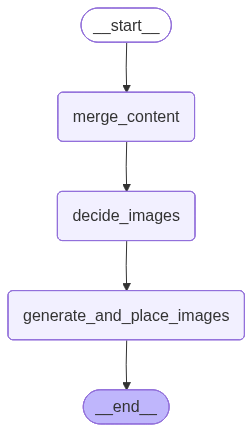

In [23]:
from langgraph.graph import StateGraph, START, END

reducer_graph = StateGraph(State)

# Subgraph nodes
reducer_graph.add_node("merge_content", merge_content)
reducer_graph.add_node("decide_images", decide_images)
reducer_graph.add_node("generate_and_place_images", generate_and_place_images)

# Edges nodes
reducer_graph.add_edge(START, "merge_content")
reducer_graph.add_edge("merge_content", "decide_images")
reducer_graph.add_edge("decide_images", "generate_and_place_images")
reducer_graph.add_edge("generate_and_place_images", END)

# Build graph
reducer_subgraph = reducer_graph.compile()

reducer_subgraph

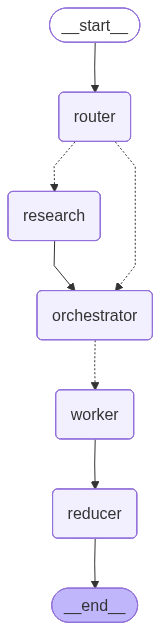

In [24]:
from langgraph.graph import StateGraph, START, END

g = StateGraph(State)

# Nodes
g.add_node("router", router_node)
g.add_node("research", research_node)
g.add_node("orchestrator", orchestrator)
g.add_node("worker", worker)
g.add_node("reducer", reducer_subgraph)

# Edges
g.add_edge(START, "router")
g.add_conditional_edges("router", route_next, {"research": "research", "orchestrator": "orchestrator"})
g.add_edge("research", "orchestrator")
g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)

# Build graph
app = g.compile()
app


In [27]:
out = app.invoke({"topic":"Transformer architecture simplified for beginners in ML"})

In [77]:
out = app.invoke({"topic":"Complete tailwind css mastery in one blog for web dev beginners from zero to hero"})

In [53]:
out = app.invoke({"topic":"Must know Deep learning interview questions to get hired"})

In [48]:
out = app.invoke({"topic":"Build a Transformer from Scratch (Without Framework Magic)"})

In [50]:
out = app.invoke({"topic":"The Complete MERN Stack Developer Guide: From Refresher to Production-Ready Architect"})

In [25]:
out = app.invoke({"topic":"Complete three.js tutorial for absoulute beginners from zero to three.js master developer"})

In [24]:
out = app.invoke({"topic":"Complete three.js mastery from zero to pro"})

C:\Users\admin\AppData\Local\Temp\ipykernel_7628\2186062612.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=max_results)


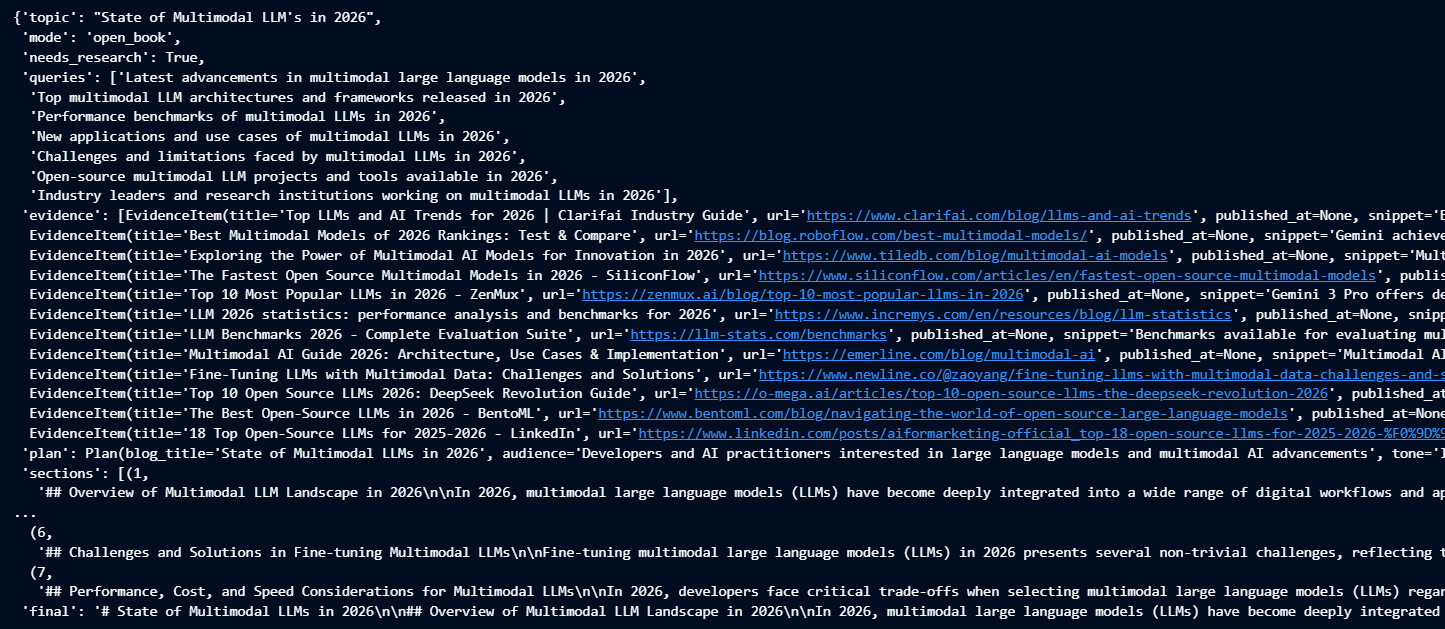